<a id="title_ID"></a>
# Beginner: Cutout of the TESS FFIs using Astrocut and Astroquery

This notebook shows the user how to use the MAST programmatic interface to create a cutout of the small section of the TESS FFIs. For this example we will determine the RA and Dec for TIC 261105201. We then perform a query to determine which sectors contain this RA and Dec, peform a cutout of the FFI time series, open the resulting target pixel files, and plot the first image of each file with the WCS overlayed on the image. Finally we will create a light curve from the resulting image by creating a photometric aperture and summing the light in our pixels.  

This tutorial shows the users how to do the following: use `astroquery.catalogs` to query the TIC, use astroquery Tesscut to determine the number of sectors that contain our target and download a FFI cutout.


### Table of Contents 
  [Astroquery Search of the TIC](#catalog_ID) <br> 
  [Tesscut to Perform FFI Cutout](#tesscut_ID) <br>
  [Create Light Curve](#lightcurve) <br>
  [Additional Resources](#resources_ID) <br> 
  [About this Notebook](#about_ID) 

***

## Import Statements
<a id="imports_ID"></a>

We start with a few import statements.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.wcs WCS* to interpret the World Coordinate Systems
- *matplotlib.pyplot* for plotting the data
- *astroquery.mast* for the catalogs and for tesscut.


In [1]:
import numpy as np
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline


***

<a id="catalog_ID"></a>
## Get Coordinates of the Target Using Astroquery Catalogs

Here we do a cone search using `Catalogs.query_object` on the TIC catalog around TIC ID = 261105201. The advantage of doing this (instead of a directly criteria query on the Tess Input Catalog) is that it gives us the nearby stars as well as the star we are looking for. The resulting table is sorted by distance from the requested object. We print out the ID and a few other TIC quantities to ensure we found the star we were looking for. 

In [2]:
ticid = 261105201

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
261105201  8.3629   7.74 82.8273670408244 -79.0087723001529    STAR
724151530 18.7511    nan 82.8150127457216 -79.0132058191133    STAR
261105202 15.6838 13.738  82.807947620659 -79.0136350375361    STAR
724151528 20.1425    nan   82.79364170498 -79.0085739998184    STAR
724151541 19.6238    nan 82.8606445683429 -79.0110416543022    STAR


In [3]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

12

***

## Query Which Sectors are Available
<a id="catalog_ID"></a>
Using the TESS sector information service, we make a request to determine which sectors/cameras/CCDs contain data for this target. Remember that there is a set of FFIs for each TESS sector and those are broken up into 4 cameras which each have 4 CCDs.  We will do this with a radius=0 cone search to find only those FFI sets that contain the star of interest. You can also make the query using a larger radius, which may be important if the star is near the edge of one of the CCDs.

In [4]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-4-2      1      4   2
tess-s0002-4-2      2      4   2
tess-s0004-4-3      4      4   3
tess-s0005-4-3      5      4   3
tess-s0007-4-4      7      4   4
tess-s0008-4-4      8      4   4
tess-s0009-4-4      9      4   4
tess-s0010-4-1     10      4   1
tess-s0011-4-1     11      4   1
tess-s0012-4-1     12      4   1
tess-s0013-3-3     13      3   3


The resulting table shows that this target was observed in two different sectors using the same camera and CCD.

***

<a id="tesscut_ID"></a>
## Request pixel timeseries cutout from TESS FFIs
Astrocut is the tool that runs the cutout service around the RA and Dec that were requested. It delivers a zipped file containing a cutout for each set of FFIs as listed above. It is also possible to request only one sector using the "sector" parameter.  
<br>
For tesscut, ***x*** refers to the CCD columns and ***y*** refers to the CCD rows. Distance can be input in a variety of units, I chose pixels ("px").

In [5]:
hdulist = Tesscut.get_cutouts(coord, 20)

Notice that this returns a **list** of HDUlist objects, one for each of our files.  HDUlist objects are the same thing you get back as if you downloaded the file and then run the following on the file: 
`hdu =  astropy.io.fits.open(FITS_file_name)`

In [6]:
hdulist[0].info()
hdulist[0][0].header['SECTOR']

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


1

In [7]:
hdulist[1].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1245R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


[Top of Page](#title_ID)

***

<a id="plot_image"></a>
## Plot the First Image of the Time Series
Here we show you some of the information found in the cutout. The format is identical to a TESS target pixel file. You should read through the target pixel file tutorial if you are not familiar with that file type.  

The pixel-level data is stored in the first PIXELS extension, including an array of the calibrated pixels for each time stamp. See the column called 'FLUX'. 


In [8]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Text(0, 0.5, 'Image Row')

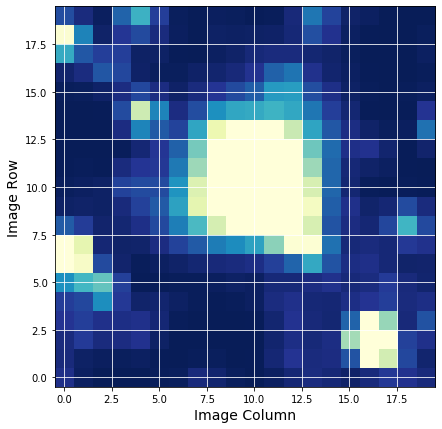

In [9]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)


### Show the first image of the second file 
We also add a WCS to the image and mark the requested star as well as nearby stars.
We use the WCS in the header to place a red dot on the image for the catalog position of the star on the figure as a demonstration of the WCS. The orange dots are the nearby stars found in the cone search done above. 

**Note. The WCS is based on the WCS stored in the FFI file for the central part of the time series and there can be some motion during a sector of observation.**

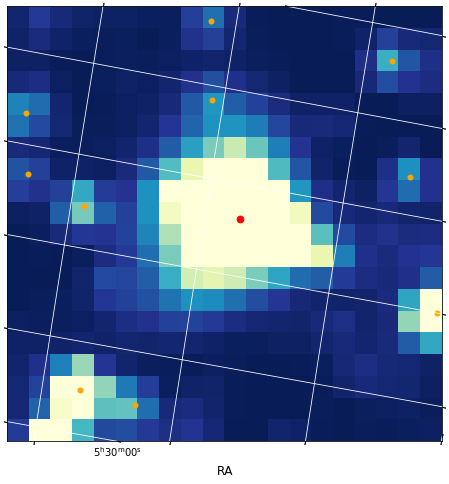

In [10]:
hdu2 = hdulist[1]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

<a id="lightcurve"></a>
## Create a Light Curve from the Cutout

We create two functions.  One to appply a photometric aperture to one image and the other to then apply that to all the images in the FLUX array.

In [11]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux


### Create a photometric time series using all the pixels in the image.
The third extension indicates which pixels have data in your image. To use all the returned pixels, we set our 2D aperture array to be True for all those with a value of 1 in that image. 

Text(0.5, 1.0, 'Flux in Photometric Aperture')

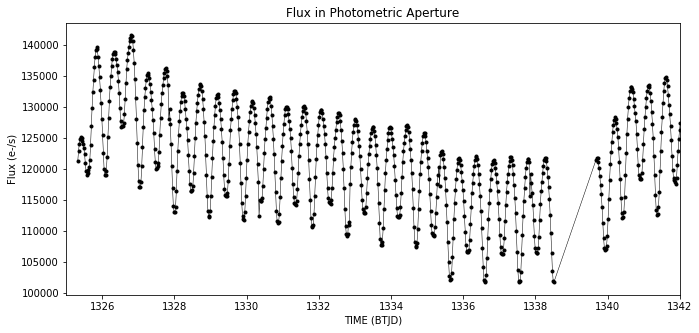

In [12]:
# Use all pixels in our aperture.
aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)
plt.xlim(1325,1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')

### Estimate the background
No background subtraction has been performed on these images.  We estimate the background by using numpy's percentile function and selecting those pixels from the first image below the 5th percentile as a way of estimating the background.

Text(0.5, 1.0, 'Background Flux')

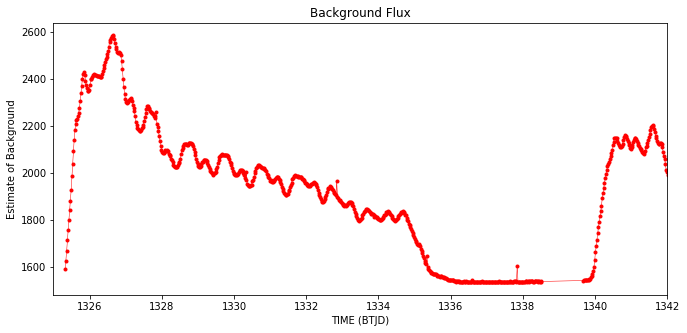

In [13]:
# Plot the flux change of the dimmest pixels by using percentile.
bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

plt.xlim(1325, 1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

### Subtract the background from the flux time series
Subtract this background after accounting for the number of pixels used to estimate the flux of the background relative to the entire image.  The final plot shows that the background subtraction removed much of unexpected variation.  This is likely an eclipsing binary system.  

Text(0.5, 1.0, 'Background Subtracted Flux')

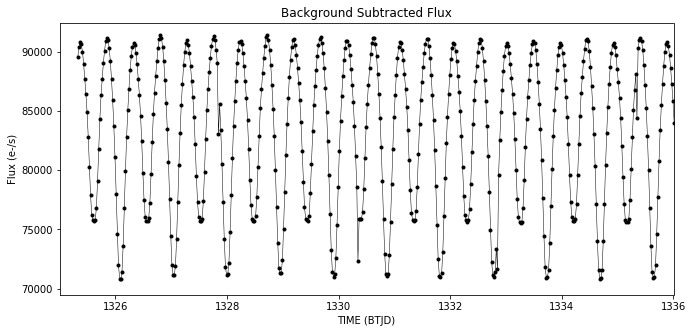

In [14]:
bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

plt.xlim(1325, 1336)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')

<a id="resources_ID"></a>
## Additional Resources
[TESScut API Documentation](https://mast.stsci.edu/tesscut/)<br>
[Astrocut Documentation](https://astrocut.readthedocs.io/en/latest/)<br>
[TESS Homepage](https://archive.stsci.edu/tess)<br>
[TESS Archive Manual](https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual)


***

<a id="about_ID"></a>
## About this Notebook
**Author:** Susan E. Mullally, STScI Archive Scientist
<br>**Updated On:** 2018-12-03

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 